In [1]:
import pandas as pd 
import numpy as np
from numpy import *

import time
import warnings
import os

from datetime import datetime
from datetime import timedelta

from scipy import sparse
import scipy.stats as stats
import math
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import metrics
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression



## Approach: 
Even though this looks like a forecasting problem, the dataset provided does not have the proper timeseries data to do a simple Forecast model.<br>
Also there are other features to be considered like holiday sales,size of the store etc to be able to do a comprehensive analysis of the dataset.<br><br>
Hence we will be doing **Regression Modelling** to get the Weekly sales number for testing set.

## Data Cleaning and feature engineering:
We will merge features and stores dataset with the sales data to get relevant features for the regression model.


In [2]:
#Loading data set
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
stores_df = pd.read_csv("data/stores.csv")
features_df = pd.read_csv("data/features.csv")

In [3]:
# Since we have to do conversions etc on both train and test data, we will append them together for now
# Adding an identifiable column to separate train and test data
train_df["table"] = "train"
test_df["table"] = "test"
#Also adding dummy Weekly_Sales in test df for easy append
test_df["Weekly_Sales"] = np.nan


#Concat both the df
sales_data_df = pd.concat([train_df,test_df],axis =0,sort = True)
sales_data_df.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table
0,2010-02-05,1,False,1,24924.50,train
1,2010-02-12,1,True,1,46039.49,train
2,2010-02-19,1,False,1,41595.55,train
3,2010-02-26,1,False,1,19403.54,train
4,2010-03-05,1,False,1,21827.90,train


In [4]:
sales_data_df.tail()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table
115059,2013-06-28,98,False,45,NaN,test
115060,2013-07-05,98,False,45,NaN,test
115061,2013-07-12,98,False,45,NaN,test
115062,2013-07-19,98,False,45,NaN,test
115063,2013-07-26,98,False,45,NaN,test


In [5]:
#Merging features and Stores data with Sales data
sales_data_df = pd.merge(sales_data_df, features_df, on=['Store','Date','IsHoliday'],how='inner')
sales_data_df = pd.merge(sales_data_df, stores_df, on=['Store'],how='inner')
sales_data_df.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,2010-02-05,1,False,1,24924.50,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,2010-02-05,2,False,1,50605.27,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,2010-02-05,3,False,1,13740.12,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,2010-02-05,4,False,1,39954.04,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,2010-02-05,5,False,1,32229.38,train,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [6]:
# To check how the dataset looks
sales_data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Dept,536634.0,44.277301,30.527358,1.000,18.000000,37.00000,74.000000,99.000000
Store,536634.0,22.208621,12.790580,1.000,11.000000,22.00000,33.000000,45.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,536634.0,58.771762,18.678716,-7.290,45.250000,60.06000,73.230000,101.950000
Fuel_Price,536634.0,3.408310,0.430861,2.472,3.041000,3.52300,3.744000,4.468000
MarkDown1,265596.0,7438.004144,9411.341379,-2781.450,2114.640000,5126.54000,9303.850000,103184.980000
MarkDown2,197685.0,3509.274827,8992.047197,-265.760,72.500000,385.31000,2392.390000,104519.540000
MarkDown3,242326.0,1857.913525,11616.143274,-179.260,7.220000,40.76000,174.260000,149483.310000
MarkDown4,237143.0,3371.556866,6872.281734,0.220,336.240000,1239.04000,3397.080000,67474.850000
MarkDown5,266496.0,4324.021158,13549.262124,-185.170,1570.112500,2870.91000,5012.220000,771448.100000


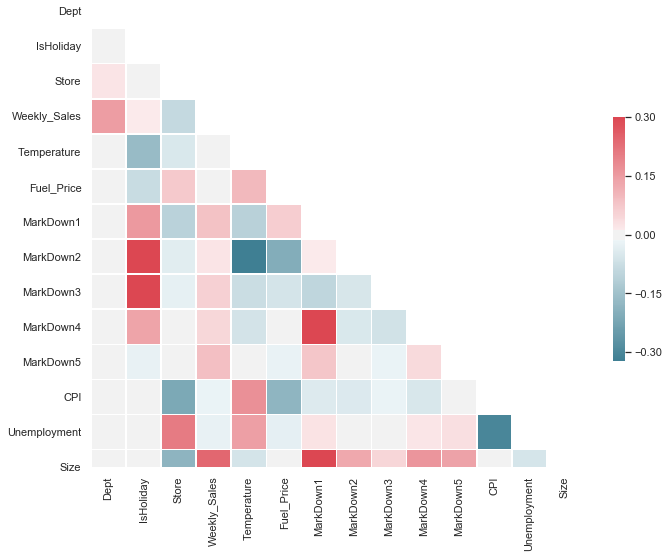

In [7]:
# Plotting a diagonal correlation matrix, to reduce clutter
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Just to see in a prelim phase which features have an impact on Weekly Sales
sns.set(style="white")

# Compute the correlation matrix
corr = sales_data_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Prelim view shows relatively higher correlation between Weekly Sales and :
1. Dept
2. Store
3. Markdown days, Holidays
4. Size of the store

We will try and find out if there are certain dates also on which Sales are affected and if they should be included in new features

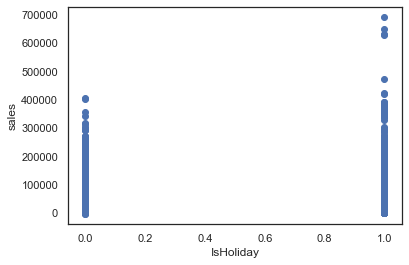

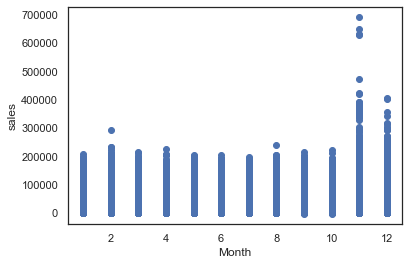

In [8]:
%matplotlib inline

# Since we will be checking relations of multiple variables, creating a def for easier coding
def udf_scatterplots(feature, label):
    x = feature
    y = sales_data_df['Weekly_Sales']
    plt.scatter(x, y)
    plt.ylabel('sales')
    plt.xlabel(label)
    plt.show()

headers = list(sales_data_df)
labels = headers

#Plot 1
udf_scatterplots(sales_data_df['IsHoliday'], 'IsHoliday')

#Plot 2
sales_data_df["Month"] = pd.DatetimeIndex(sales_data_df['Date']).month
udf_scatterplots(sales_data_df['Month'], 'Month')


There is a definite spike in sales during Novemeber and some in Dec, the onset of US holiday season.<br>
We will check on the dates with higher sales (>30000),which seems to be the cutoff for other months.

In [9]:
sales_data_df.loc[sales_data_df['Weekly_Sales'] >300000]

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month
40647,2010-11-26,72,True,4,381072.11,train,48.08,2.752,NaN,NaN,NaN,NaN,NaN,126.669267,7.127,A,205863,11
44365,2011-11-25,72,True,4,385051.04,train,47.96,3.225,561.45,137.88,83340.33,44.04,9239.23,129.836400,5.143,A,205863,11
44610,2011-12-23,7,False,4,318422.01,train,35.92,3.103,2461.94,69.05,2938.24,52.00,4396.76,129.984548,5.143,A,205863,12
65129,2010-11-26,72,True,6,342578.65,train,65.79,2.735,NaN,NaN,NaN,NaN,NaN,213.267296,7.007,A,202505,11
68848,2011-11-25,72,True,6,326866.60,train,62.78,3.236,429.03,171.88,83192.81,15.00,986.23,220.041741,6.551,A,202505,11
114539,2010-11-26,72,True,10,693099.36,train,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,11
114780,2010-12-24,7,False,10,406988.63,train,57.06,3.236,NaN,NaN,NaN,NaN,NaN,126.983581,9.003,B,126512,12
114830,2010-12-24,72,False,10,404245.03,train,57.06,3.236,NaN,NaN,NaN,NaN,NaN,126.983581,9.003,B,126512,12
118287,2011-11-25,72,True,10,630999.19,train,60.68,3.760,174.72,329.00,141630.61,79.00,1009.98,129.836400,7.874,B,126512,11
118528,2011-12-23,7,False,10,341308.00,train,48.36,3.541,300.02,77.73,2432.01,108.37,4078.21,129.984548,7.874,B,126512,12


So, we can see a lot of records corresponding to Black Friday Sale in USA - `26 Nov 2010 and 25 Nov 2011`<br>
Other than that there are some spikes before Christmas as well.<br>

Hence, we will define two more dummy variables - `Black Friday Dates and Christmas Dates(actually two dates prior to 25-Dec)`
<br>


### Treating Missing Value

In [10]:
# Checking on Missing Values
#sales_data_df = sales_data_df_copy.copy()
sales_data_df.isnull().sum()

Date                 0
Dept                 0
IsHoliday            0
Store                0
Weekly_Sales    115064
table                0
Temperature          0
Fuel_Price           0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
CPI              38162
Unemployment     38162
Type                 0
Size                 0
Month                0
dtype: int64

Alongwith value of the markdowns, we will also create features that will identify if the Markdowns were available at all.

In [11]:
sales_data_df = sales_data_df.assign(md1_available = sales_data_df.MarkDown1.notnull())
sales_data_df = sales_data_df.assign(md2_available = sales_data_df.MarkDown2.notnull())
sales_data_df = sales_data_df.assign(md3_available = sales_data_df.MarkDown3.notnull())
sales_data_df = sales_data_df.assign(md4_available = sales_data_df.MarkDown4.notnull())
sales_data_df = sales_data_df.assign(md5_available = sales_data_df.MarkDown5.notnull())
sales_data_df.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,CPI,Unemployment,Type,Size,Month,md1_available,md2_available,md3_available,md4_available,md5_available
0,2010-02-05,1,False,1,24924.50,train,42.31,2.572,NaN,NaN,...,211.096358,8.106,A,151315,2,False,False,False,False,False
1,2010-02-05,2,False,1,50605.27,train,42.31,2.572,NaN,NaN,...,211.096358,8.106,A,151315,2,False,False,False,False,False
2,2010-02-05,3,False,1,13740.12,train,42.31,2.572,NaN,NaN,...,211.096358,8.106,A,151315,2,False,False,False,False,False
3,2010-02-05,4,False,1,39954.04,train,42.31,2.572,NaN,NaN,...,211.096358,8.106,A,151315,2,False,False,False,False,False
4,2010-02-05,5,False,1,32229.38,train,42.31,2.572,NaN,NaN,...,211.096358,8.106,A,151315,2,False,False,False,False,False


In [12]:
# Replacing missing values in Markdowns with 0
sales_data_df["MarkDown1"].fillna(0, inplace=True)
sales_data_df["MarkDown2"].fillna(0, inplace=True)
sales_data_df["MarkDown3"].fillna(0, inplace=True)
sales_data_df["MarkDown4"].fillna(0, inplace=True)
sales_data_df["MarkDown5"].fillna(0, inplace=True)

sales_data_df.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,CPI,Unemployment,Type,Size,Month,md1_available,md2_available,md3_available,md4_available,md5_available
0,2010-02-05,1,False,1,24924.50,train,42.31,2.572,0.0,0.0,...,211.096358,8.106,A,151315,2,False,False,False,False,False
1,2010-02-05,2,False,1,50605.27,train,42.31,2.572,0.0,0.0,...,211.096358,8.106,A,151315,2,False,False,False,False,False
2,2010-02-05,3,False,1,13740.12,train,42.31,2.572,0.0,0.0,...,211.096358,8.106,A,151315,2,False,False,False,False,False
3,2010-02-05,4,False,1,39954.04,train,42.31,2.572,0.0,0.0,...,211.096358,8.106,A,151315,2,False,False,False,False,False
4,2010-02-05,5,False,1,32229.38,train,42.31,2.572,0.0,0.0,...,211.096358,8.106,A,151315,2,False,False,False,False,False


In [13]:
# Replacing CPI and Unemployment missing data with average of that particular store
# Since these metrics are location specific

CPI_df = pd.DataFrame(sales_data_df.groupby("Store")["CPI"].mean())
Unemp_df = pd.DataFrame(sales_data_df.groupby("Store")["Unemployment"].mean())

for ind in sales_data_df.index:
    if (math.isnan(sales_data_df.loc[ind,"CPI"])):
        store = sales_data_df.loc[ind,"Store"]
        sales_data_df.loc[ind,"CPI"] = CPI_df.loc[store,"CPI"]
    if (math.isnan(sales_data_df.loc[ind,"Unemployment"])):
        store = sales_data_df.loc[ind,"Store"]
        sales_data_df.loc[ind,"Unemployment"] = Unemp_df.loc[store,"Unemployment"]

In [14]:
# Save point!
sales_data_df_1 = sales_data_df.copy()

### Feature Engineering:

This is not technically a forecast model, but we have definitely witnessed seasonality in our data.<br>
Since we cannot use "Date" variable in our regression, we will instead derive a lagged variable representing the flow of time.
<br><br>
Also if we create dummies for each store and dept, we will have too many columns, which might not be worth considering. Instead we will use geographic data to represent a store like CPI, Unemployment, Median sale of the store.<br> 

**Lagged Weekly Sales Variable Addition**<br>
we will use a date related column of 1-lagged weekly sales data

In [15]:
sales_data_df.Date = pd.to_datetime(sales_data_df.Date)

In [16]:
# 1st identify the previous week
sales_data_df['DateLagged'] = sales_data_df['Date']-pd.to_timedelta(7, unit='D')
sales_data_df.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,Type,Size,Month,md1_available,md2_available,md3_available,md4_available,md5_available,DateLagged
0,2010-02-05,1,False,1,24924.50,train,42.31,2.572,0.0,0.0,...,8.106,A,151315,2,False,False,False,False,False,2010-01-29
1,2010-02-05,2,False,1,50605.27,train,42.31,2.572,0.0,0.0,...,8.106,A,151315,2,False,False,False,False,False,2010-01-29
2,2010-02-05,3,False,1,13740.12,train,42.31,2.572,0.0,0.0,...,8.106,A,151315,2,False,False,False,False,False,2010-01-29
3,2010-02-05,4,False,1,39954.04,train,42.31,2.572,0.0,0.0,...,8.106,A,151315,2,False,False,False,False,False,2010-01-29
4,2010-02-05,5,False,1,32229.38,train,42.31,2.572,0.0,0.0,...,8.106,A,151315,2,False,False,False,False,False,2010-01-29


In [17]:
# Make a sorted dataframe
sales_data_df = sales_data_df.sort_values(['Store', 'Dept','Date'], ascending=[1, 1,1])
sales_data_df = sales_data_df.reset_index(drop=True)

In [18]:
# Just in case we have any data missing for a week, we can substitute the same with the median value of the Dept
# We will include IsHoliday & Month in group by, since median will fluctuate in holiday season as we have seen
# Only selecting training data to get median, else it might come up as 0
medians = pd.DataFrame({'Median_Sales' :sales_data_df.loc[sales_data_df['table']=='train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
sales_data_df = sales_data_df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])
sales_data_df.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Type,Size,Month,md1_available,md2_available,md3_available,md4_available,md5_available,DateLagged,Median_Sales
0,2010-02-05,1,False,1,24924.50,train,42.31,2.572,0.0,0.0,...,A,151315,2,False,False,False,False,False,2010-01-29,23510.49
1,2010-02-19,1,False,1,41595.55,train,39.93,2.514,0.0,0.0,...,A,151315,2,False,False,False,False,False,2010-02-12,23510.49
2,2010-02-26,1,False,1,19403.54,train,46.63,2.561,0.0,0.0,...,A,151315,2,False,False,False,False,False,2010-02-19,23510.49
3,2011-02-04,1,False,1,21665.76,train,42.27,2.989,0.0,0.0,...,A,151315,2,False,False,False,False,False,2011-01-28,23510.49
4,2011-02-18,1,False,1,46845.87,train,57.36,3.045,0.0,0.0,...,A,151315,2,False,False,False,False,False,2011-02-11,23510.49


In [19]:
sales_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536634 entries, 0 to 536633
Data columns (total 25 columns):
Date             536634 non-null datetime64[ns]
Dept             536634 non-null int64
IsHoliday        536634 non-null bool
Store            536634 non-null int64
Weekly_Sales     421570 non-null float64
table            536634 non-null object
Temperature      536634 non-null float64
Fuel_Price       536634 non-null float64
MarkDown1        536634 non-null float64
MarkDown2        536634 non-null float64
MarkDown3        536634 non-null float64
MarkDown4        536634 non-null float64
MarkDown5        536634 non-null float64
CPI              536634 non-null float64
Unemployment     536634 non-null float64
Type             536634 non-null object
Size             536634 non-null int64
Month            536634 non-null int64
md1_available    536634 non-null bool
md2_available    536634 non-null bool
md3_available    536634 non-null bool
md4_available    536634 non-null bool
md5_a

In [20]:
sales_data_df['Median_Sales'].fillna(sales_data_df['Median_Sales'].loc[sales_data_df['table']=='train'].median(), inplace=True) 
sales_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536634 entries, 0 to 536633
Data columns (total 25 columns):
Date             536634 non-null datetime64[ns]
Dept             536634 non-null int64
IsHoliday        536634 non-null bool
Store            536634 non-null int64
Weekly_Sales     421570 non-null float64
table            536634 non-null object
Temperature      536634 non-null float64
Fuel_Price       536634 non-null float64
MarkDown1        536634 non-null float64
MarkDown2        536634 non-null float64
MarkDown3        536634 non-null float64
MarkDown4        536634 non-null float64
MarkDown5        536634 non-null float64
CPI              536634 non-null float64
Unemployment     536634 non-null float64
Type             536634 non-null object
Size             536634 non-null int64
Month            536634 non-null int64
md1_available    536634 non-null bool
md2_available    536634 non-null bool
md3_available    536634 non-null bool
md4_available    536634 non-null bool
md5_a

In [21]:
#Loop to check if previous week data is available, else sub with median walue for the lagged variable

sales_data_df['Lagged_Sales'] = np.nan
sales_data_df['Lagged_Avail'] = np.nan
last=sales_data_df.loc[0]
row_len = sales_data_df.shape[0]
for index, row in sales_data_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['Date']== lag_date) & (last['Weekly_Sales']>0)): 
        sales_data_df.at[index, 'Lagged_Sales'] = last['Weekly_Sales']
        sales_data_df.at[index, 'Lagged_Avail'] = 1
    else:
        sales_data_df.at[index, 'Lagged_Sales'] = row['Median_Sales']
        sales_data_df.at[index, 'Lagged_Avail'] = 0

    last = row

In [22]:
# Since NaN values of Weekly Sales are anyway we are going to predict.
sales_data_df["Weekly_Sales"].fillna(0, inplace=True)
sales_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536634 entries, 0 to 536633
Data columns (total 27 columns):
Date             536634 non-null datetime64[ns]
Dept             536634 non-null int64
IsHoliday        536634 non-null bool
Store            536634 non-null int64
Weekly_Sales     536634 non-null float64
table            536634 non-null object
Temperature      536634 non-null float64
Fuel_Price       536634 non-null float64
MarkDown1        536634 non-null float64
MarkDown2        536634 non-null float64
MarkDown3        536634 non-null float64
MarkDown4        536634 non-null float64
MarkDown5        536634 non-null float64
CPI              536634 non-null float64
Unemployment     536634 non-null float64
Type             536634 non-null object
Size             536634 non-null int64
Month            536634 non-null int64
md1_available    536634 non-null bool
md2_available    536634 non-null bool
md3_available    536634 non-null bool
md4_available    536634 non-null bool
md5_a

In [29]:
#Save Point!
#sales_data_df = sales_data_df_2.copy()

### Cleaning and creating relatable variables: 
**1. Categorical Data: Turn Boolean columns into 1 or 0**

In [23]:
sales_data_df['IsHoliday'] = sales_data_df['IsHoliday'].apply(lambda x: 1 if x== True else 0)
sales_data_df['md1_available'] = sales_data_df['md1_available'].apply(lambda x: 1 if x== True else 0)
sales_data_df['md2_available'] = sales_data_df['md2_available'].apply(lambda x: 1 if x== True else 0)
sales_data_df['md3_available'] = sales_data_df['md3_available'].apply(lambda x: 1 if x== True else 0)
sales_data_df['md4_available'] = sales_data_df['md4_available'].apply(lambda x: 1 if x== True else 0)
sales_data_df['md5_available'] = sales_data_df['md5_available'].apply(lambda x: 1 if x== True else 0)

**2. Creating relevant Date Data**<br>
We have the Nov of year 2010, 2011 in training and 2012 in test. So dates for Black Friday on these three years<br>
 - 26 Nov 2010
 - 25 Nov 2011
 - 23 Nov 2012

In [24]:
sales_data_df['Black_Friday'] = np.where((sales_data_df['Date']== "2010-11-26" ) | (sales_data_df['Date']== "2011-11-25" )|(sales_data_df['Date']== "2012-11-23" ), 1, 0)
sales_data_df['Pre_christmas'] = np.where((sales_data_df['Date']== "2010-12-23" ) | (sales_data_df['Date']== "2010-12-24" ) | (sales_data_df['Date']== "2011-12-23" ) | (sales_data_df['Date']== "2011-12-24" )|(sales_data_df['Date']== "2012-12-23" )|(sales_data_df['Date']== "2012-12-24" ), 1, 0)


In [32]:
sales_data_df.head(2)

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,md2_available,md3_available,md4_available,md5_available,DateLagged,Median_Sales,Lagged_Sales,Lagged_Avail,Black_Friday,Pre_christmas
0,2010-02-05,1,0,1,24924.50,train,42.31,2.572,0.0,0.0,...,0,0,0,0,2010-01-29,23510.49,23510.49,0.0,0,0
1,2010-02-19,1,0,1,41595.55,train,39.93,2.514,0.0,0.0,...,0,0,0,0,2010-02-12,23510.49,23510.49,0.0,0,0


In [25]:
# Scaling the data, so we can scale test data too - not all continuous columns
sales_data_df['Unemployment'] = (sales_data_df['Unemployment'] - sales_data_df['Unemployment'].mean())/(sales_data_df['Unemployment'].std())
sales_data_df['Temperature'] = (sales_data_df['Temperature'] - sales_data_df['Temperature'].mean())/(sales_data_df['Temperature'].std())
sales_data_df['Fuel_Price'] = (sales_data_df['Fuel_Price'] - sales_data_df['Fuel_Price'].mean())/(sales_data_df['Fuel_Price'].std())
sales_data_df['CPI'] = (sales_data_df['CPI'] - sales_data_df['CPI'].mean())/(sales_data_df['CPI'].std())
sales_data_df['MarkDown1'] = (sales_data_df['MarkDown1'] - sales_data_df['MarkDown1'].mean())/(sales_data_df['MarkDown1'].std())
sales_data_df['MarkDown2'] = (sales_data_df['MarkDown2'] - sales_data_df['MarkDown2'].mean())/(sales_data_df['MarkDown2'].std())
sales_data_df['MarkDown3'] = (sales_data_df['MarkDown3'] - sales_data_df['MarkDown3'].mean())/(sales_data_df['MarkDown3'].std())
sales_data_df['MarkDown4'] = (sales_data_df['MarkDown4'] - sales_data_df['MarkDown4'].mean())/(sales_data_df['MarkDown4'].std())
sales_data_df['MarkDown5'] = (sales_data_df['MarkDown5'] - sales_data_df['MarkDown5'].mean())/(sales_data_df['MarkDown5'].std())
sales_data_df['Lagged_Sales']= (sales_data_df['Lagged_Sales'] - sales_data_df['Lagged_Sales'].mean())/(sales_data_df['Lagged_Sales'].std())
sales_data_df.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,md2_available,md3_available,md4_available,md5_available,DateLagged,Median_Sales,Lagged_Sales,Lagged_Avail,Black_Friday,Pre_christmas
0,2010-02-05,1,0,1,24924.50,train,-0.881311,-1.941019,-0.48477,-0.226236,...,0,0,0,0,2010-01-29,23510.49,0.337859,0.0,0,0
1,2010-02-19,1,0,1,41595.55,train,-1.008729,-2.075633,-0.48477,-0.226236,...,0,0,0,0,2010-02-12,23510.49,0.337859,0.0,0,0
2,2010-02-26,1,0,1,19403.54,train,-0.650032,-1.966549,-0.48477,-0.226236,...,0,0,0,0,2010-02-19,23510.49,1.141591,1.0,0,0
3,2011-02-04,1,0,1,21665.76,train,-0.883453,-0.973190,-0.48477,-0.226236,...,0,0,0,0,2011-01-28,23510.49,0.337859,0.0,0,0
4,2011-02-18,1,0,1,46845.87,train,-0.075581,-0.843218,-0.48477,-0.226236,...,0,0,0,0,2011-02-11,23510.49,0.337859,0.0,0,0


In [26]:
# Since we are scaling the data, it would be better to get the Weekly Sales at the same level as well
# Using Difference of median to Weekly Sales to get new forecasting variable
sales_data_df['Y_Diff'] = sales_data_df['Median_Sales'] - sales_data_df['Weekly_Sales']


**Checking on correlation Matrix**

In [27]:
df = sales_data_df.copy()
df.drop(["Store","Dept","Month","Weekly_Sales"],axis =1,inplace=True)

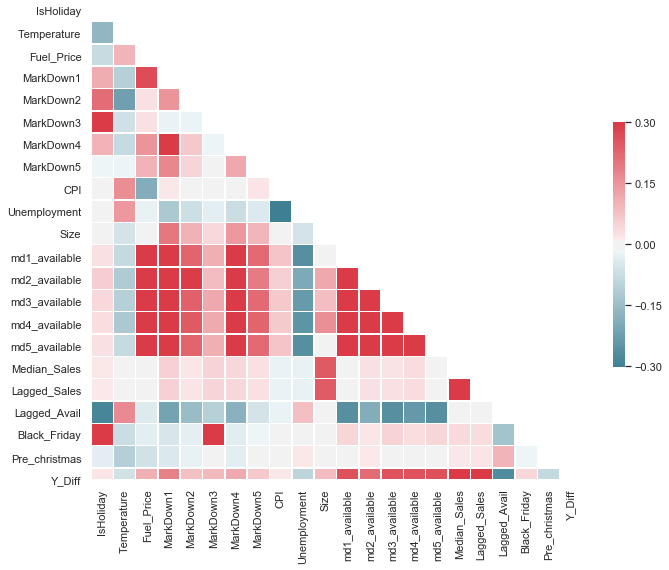

In [28]:
# Plotting a diagonal correlation matrix, to reduce clutter
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [29]:
# Median Sale and Lagged Sale have some higher corr with datasets.
# Adding another feature
sales_data_df['Lagged_Diff'] = sales_data_df["Median_Sales"] - sales_data_df["Lagged_Sales"]

### Separating Train and Test data

In [30]:
training_df = sales_data_df[sales_data_df["table"]=="train"].copy()
testing_df = sales_data_df[sales_data_df["table"]=="test"].copy()
print(training_df.shape)
print(testing_df.shape)

(421570, 31)
(115064, 31)


In [68]:
all_training_df = sales_data_df[sales_data_df["table"]=="train"].copy()

In [31]:
# Leaving out some of the columns when doing further modelling
del_col = ["Type","Store","Dept","Date","DateLagged","Month","table","Weekly_Sales","Median_Sales"]
training_df = training_df[training_df.columns.difference(del_col)].copy()
training_df.head()

,Black_Friday,CPI,Fuel_Price,IsHoliday,Lagged_Avail,Lagged_Diff,Lagged_Sales,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas,Size,Temperature,Unemployment,Y_Diff,md1_available,md2_available,md3_available,md4_available,md5_available
0,0,0.986701,-1.941019,0,0.0,23510.152141,0.337859,-0.48477,-0.226236,-0.106733,...,0,151315,-0.881311,0.169549,-1414.01,0,0,0,0,0
1,0,0.991578,-2.075633,0,0.0,23510.152141,0.337859,-0.48477,-0.226236,-0.106733,...,0,151315,-1.008729,0.169549,-18085.06,0,0,0,0,0
2,0,0.992349,-1.966549,0,1.0,23509.348409,1.141591,-0.48477,-0.226236,-0.106733,...,0,151315,-0.650032,0.169549,4106.95,0,0,0,0,0
3,0,1.023900,-0.973190,0,0.0,23510.152141,0.337859,-0.48477,-0.226236,-0.106733,...,0,151315,-0.883453,-0.026781,1844.73,0,0,0,0,0
4,0,1.041128,-0.843218,0,0.0,23510.152141,0.337859,-0.48477,-0.226236,-0.106733,...,0,151315,-0.075581,-0.026781,-23335.38,0,0,0,0,0


In [32]:
#Splitting training data into train and test
X_train, X_test, y_train, y_test = train_test_split(training_df[training_df.columns.difference(["Y_Diff"])], training_df['Y_Diff'], test_size=0.2, random_state=42)


Since we only have 22 columns, we will build a number of models with all 22 of them, and pick the one with least MAE.

#### Running a GridSearchCV to get good params for a RandomForestRegressor

In [51]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=3, random_state=42, 
                      verbose=2, warm_start=False)


In [54]:
# Grid search of parameters, using 3 fold cross validation, 

from sklearn.model_selection import GridSearchCV

# Create the parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [1,2],
    'n_estimators': [19,20,21],
    'random_state': [42]
}
# Create a based model
rf_g = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_g, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [55]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 12.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [56]:
grid_search.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 21,
 'random_state': 42}

In [60]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f} degrees.'.format(np.mean(errors)))
    
    return errors

In [61]:
rf.fit(X_train, y_train)
base_accuracy = evaluate(rf, X_train, y_train)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:  1.2min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


Model Performance
Mean Absolute Error: 556.8937 degrees.


[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:    2.2s finished


In [62]:
best_model = grid_search.best_estimator_
random_accuracy = evaluate(best_model, X_train, y_train)

Model Performance
Mean Absolute Error: 718.6000 degrees.


In [63]:
rf_2 = RandomForestRegressor(n_estimators=18, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=3, random_state=42, 
                      verbose=2, warm_start=False)
rf_2.fit(X_train, y_train)
evaluate(rf_2, X_train, y_train)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 18
building tree 2 of 18
building tree 3 of 18
building tree 4 of 18
building tree 5 of 18
building tree 6 of 18
building tree 7 of 18
building tree 8 of 18
building tree 9 of 18
building tree 10 of 18
building tree 11 of 18
building tree 12 of 18
building tree 13 of 18
building tree 14 of 18
building tree 15 of 18
building tree 16 of 18
building tree 17 of 18
building tree 18 of 18


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   59.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    1.9s finished


Model Performance
Mean Absolute Error: 561.1545 degrees.


176159     325.839444
367998       1.047778
66624       84.088333
258986     546.292500
297219     959.943333
169339    2356.206389
202650     841.417778
272673     945.652222
110809     927.437500
465842    1124.010000
83137      281.954444
488172     114.910833
466248     144.075556
100523     333.688889
236857      37.304444
60990       23.658333
406439     725.802778
264965       2.849444
49770      186.907778
204723     379.995000
150648     262.086667
514748     563.847222
470190      69.284722
54768       93.830278
193297      86.657222
293858     189.024444
283213      29.341111
479316      14.224722
305523      70.461667
236715    2710.737778
             ...     
235158    1951.230278
272582     148.005556
300012     172.801389
131550     253.224444
340353    1134.827222
253311    1344.038333
321550      19.673056
416116       1.355833
246911     141.461389
409533      47.896111
334555      12.209444
82494       32.074444
419025      41.939722
52301       26.458611
353975    

### Model evaluation
 
 To evaluate the model, we will look at MAE and accuracy in terms of the number of times it correctly estimated an upward or downward deviation from the median.


In [45]:
y_train_pred_rf = rf.predict(X_train)
y_train_pred_rf_2 = rf_2.predict(X_train)

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  22 out of  22 | elapsed:    2.9s finished


In [46]:
print("MAE (Model - rf): ",mean_absolute_error(y_train,y_train_pred_rf))
print("MAE (Model - rf_2): ",mean_absolute_error(y_train,y_train_pred_rf_2))

MAE (Model - rf):  556.8937105114268
MAE (Model - rf_2):  593.540874113347


In [66]:
y_test_pred_rf = rf.predict(X_test)
print("MAE (Model - rf): ",mean_absolute_error(y_test,y_test_pred_rf))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


MAE (Model - rf):  1445.5433558743703


[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:    0.6s finished


In [67]:
y_test_pred_rf_2 = rf_2.predict(X_test)
print("MAE (Model - rf_2): ",mean_absolute_error(y_test,y_test_pred_rf_2))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


MAE (Model - rf_2):  1449.857776171678


[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    0.5s finished


In [69]:
y_test = y_test.to_frame()
y_test['Predicted'] = y_test_pred_rf
df_merged = pd.merge(all_training_df,y_test[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_merged = df_merged[~pd.isnull(df_merged['Predicted'])]
df_merged.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,md5_available,DateLagged,Median_Sales,Lagged_Sales,Lagged_Avail,Black_Friday,Pre_christmas,Y_Diff,Lagged_Diff,Predicted
2,2010-02-26,1,0,1,19403.54,train,-0.650032,-1.966549,-0.484770,-0.226236,...,0,2010-02-19,23510.49,1.141591,1.0,0,0,4106.95,23509.348409,-5402.55225
7,2012-02-17,1,0,1,54060.10,train,-0.720165,0.236016,0.815399,1.709712,...,1,2012-02-10,23510.49,0.337859,0.0,0,0,-30549.61,23510.152141,-3385.31625
14,2012-02-10,1,1,1,36988.49,train,-0.575616,0.001602,1.348951,0.986061,...,1,2012-02-03,37887.17,0.976784,0.0,0,0,898.68,37886.193216,-2760.77975
28,2012-03-30,1,0,1,28952.86,train,0.473172,1.013528,0.872846,-0.226149,...,1,2012-03-23,21280.40,0.275516,1.0,0,0,-7672.46,21280.124484,255.03000
39,2011-04-01,1,0,1,20398.09,train,0.021320,0.268509,-0.484770,-0.226236,...,0,2011-03-25,26318.08,0.462633,0.0,0,0,5919.99,26317.617367,858.92500


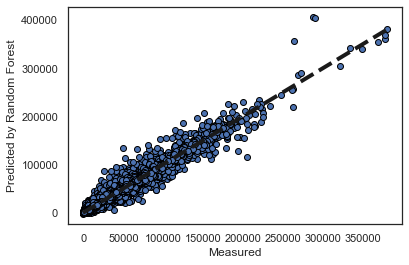

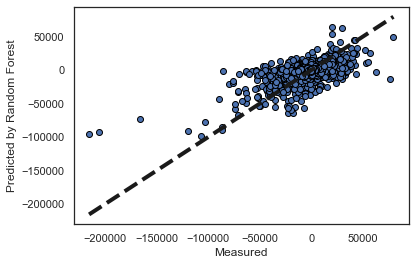

In [73]:
def plot_prediction(predicted,true,description):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+description)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()
    
#df_merged['sales_prediction'] = df_merged['Median_Sales']-df_merged['Predicted']
plot_prediction(df_merged['Weekly_Sales'],df_merged['sales_prediction'],"Random Forest")
plot_prediction(y_test_pred_rf,y_test['Y_Diff'].values,"Random Forest")

The predictions look quite decent.<br>
The initial Rgressor parameters were not improved upon by the GridSearch, hence we will consider **rf** to be the model of prediction going forward, with the lowest MAE

Now running the model on full data set to get the maximum amount of information in our model.

In [75]:
#Train on whole data
rf.fit(all_training_df[all_training_df.columns.difference(del_col)], all_training_df['Y_Diff'])

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:   52.5s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=3, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

## Forecasting sales

After we have created our model, we can predict things with it on the test set

In [77]:
final_y_prediction = rf.predict(testing_df[testing_df.columns.difference(del_col)])

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:    0.1s finished


In [78]:
testfile = pd.concat([testing_df.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['sales_prediction'] = testfile['Median_Sales']-testfile[0]
testfile.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,DateLagged,Median_Sales,Lagged_Sales,Lagged_Avail,Black_Friday,Pre_christmas,Y_Diff,Lagged_Diff,0,sales_prediction
0,2013-02-01,1,0,1,0.0,test,-0.123765,-0.381352,0.738703,0.011752,...,2013-01-25,23510.49,0.337859,0.0,0,0,23510.49,23510.152141,23490.48400,20.00600
1,2013-02-15,1,0,1,0.0,test,-0.487815,0.154783,9.119972,0.940260,...,2013-02-08,23510.49,0.337859,0.0,0,0,23510.49,23510.152141,23494.23950,16.25050
2,2013-02-22,1,0,1,0.0,test,-0.456228,0.437937,2.163118,0.327459,...,2013-02-15,23510.49,0.337859,0.0,0,0,23510.49,23510.152141,23491.12300,19.36700
3,2013-02-08,1,1,1,0.0,test,-0.112522,0.020169,3.775917,-0.098518,...,2013-02-01,37887.17,0.976784,0.0,0,0,37887.17,37886.193216,37899.64025,-12.47025
4,2013-03-01,1,0,1,0.0,test,-0.576151,0.702523,0.912504,-0.180480,...,2013-02-22,21280.40,0.238749,0.0,0,0,21280.40,21280.161251,21280.38550,0.01450


Creating the sampleSubmission file

In [80]:
testfile['Store'] = 'Store_' + testfile['Store'].map(str)
testfile['Dept'] = 'Dept_' + testfile['Dept'].map(str)
testfile.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,table,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,DateLagged,Median_Sales,Lagged_Sales,Lagged_Avail,Black_Friday,Pre_christmas,Y_Diff,Lagged_Diff,0,sales_prediction
0,2013-02-01,Dept_1,0,Store_1,0.0,test,-0.123765,-0.381352,0.738703,0.011752,...,2013-01-25,23510.49,0.337859,0.0,0,0,23510.49,23510.152141,23490.48400,20.00600
1,2013-02-15,Dept_1,0,Store_1,0.0,test,-0.487815,0.154783,9.119972,0.940260,...,2013-02-08,23510.49,0.337859,0.0,0,0,23510.49,23510.152141,23494.23950,16.25050
2,2013-02-22,Dept_1,0,Store_1,0.0,test,-0.456228,0.437937,2.163118,0.327459,...,2013-02-15,23510.49,0.337859,0.0,0,0,23510.49,23510.152141,23491.12300,19.36700
3,2013-02-08,Dept_1,1,Store_1,0.0,test,-0.112522,0.020169,3.775917,-0.098518,...,2013-02-01,37887.17,0.976784,0.0,0,0,37887.17,37886.193216,37899.64025,-12.47025
4,2013-03-01,Dept_1,0,Store_1,0.0,test,-0.576151,0.702523,0.912504,-0.180480,...,2013-02-22,21280.40,0.238749,0.0,0,0,21280.40,21280.161251,21280.38550,0.01450


In [81]:
output = pd.DataFrame({'id':pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Store']]).map(str) + '_' +
                           pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Dept']]).map(str)  + '_' +
                           testfile['Date'].map(str),
                          'Weekly_Sales':testfile['sales_prediction']})
output.head()

,id,Weekly_Sales
0,1_1_2013-02-01 00:00:00,20.00600
1,1_1_2013-02-15 00:00:00,16.25050
2,1_1_2013-02-22 00:00:00,19.36700
3,1_1_2013-02-08 00:00:00,-12.47025
4,1_1_2013-03-01 00:00:00,0.01450


Check submission one more time

In [82]:
output.to_csv('final_output.csv',index=False)